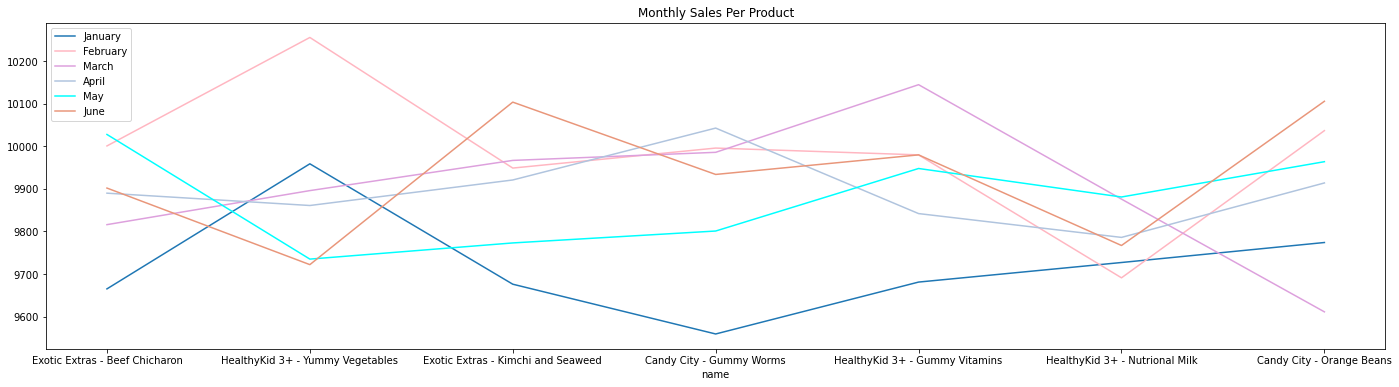

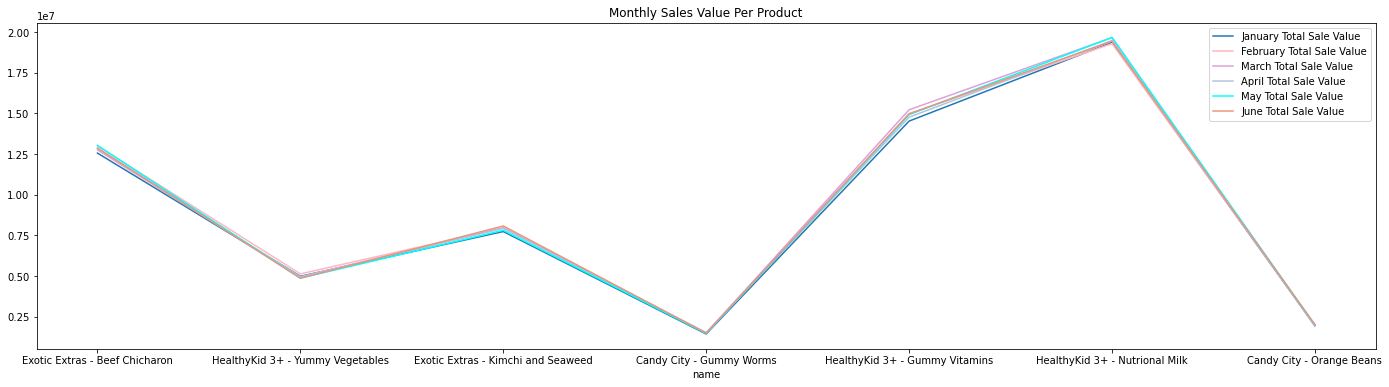

In [8]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


#Load json file as dataframe
with open("transaction-data-adhoc-analysis (1).json") as g:
    data=pd.read_json(g)
df=pd.DataFrame.from_dict(data)

#SALES
#remove ";" from transactions with multiple items
def transaction_items_split(transaction_items):
    item_list=transaction_items.split(";")
    return item_list
df["new_transaction_items"]=df["transaction_items"].apply(transaction_items_split)

#Find price for items bought alone
price_list_dict={}
def indiv_price(new_transaction_items, transaction_value):
    item_list=new_transaction_items
    for item in item_list:
        name=item.split(",")[0] + " - " + item.split(",")[1]
        num=re.search(r"\(x([0-9]*)\)", item.split(",")[-1]).group(1) 
        qty=int(num)
        if len(item_list)==1:
            price = int(transaction_value) / qty
            if name not in price_list_dict.keys():  
                price_list_dict[name]=price
df.apply(lambda x: indiv_price(x["new_transaction_items"], x["transaction_value"]), axis=1)

#Dataframe for all products bought
all_products_arr=[]
def AllProducts(new_transaction_items, transaction_value, transaction_date, price_list_dict):
    item_list=new_transaction_items
    for item in item_list:
        brand=item.split(",")[0]
        product=item.split(",")[1]
        name=brand + " - " + product
        num=re.search(r"\(x([0-9]*)\)", item.split(",")[-1]).group(1) #since quantities were written with x(number)
        qty=int(num) 
        year, month, day=[ int(x) for x in transaction_date.split("/") ]
        price_for_one=price_list_dict[name]
        total_price=price_for_one * qty
        
        all_products_arr.append({"Product": name, "qty": qty, "Price Each": price_for_one, "Total Price": total_price, "Year": year, "Month": month, "Day": day})
df.apply(lambda x: AllProducts(x["new_transaction_items"], x["transaction_value"], x["transaction_date"], price_list_dict), axis=1)
all_products_df=pd.DataFrame(all_products_arr)

#Find list of names of unique products
def ItemsListUnique(price_list_dict):
    arr=[]
    for key in price_list_dict:
        arr.append({"name":key})
    return arr
items_list_unique=ItemsListUnique(price_list_dict)

#Finding total number of products sold per month
def TotalItems(Product, qty, Month): 
    month_names=["January","February","March","April","May","June"]
    month_name=month_names[Month-1]
    for i in range(0, len(items_list_unique)):
        if items_list_unique[i]["name"]==Product:
            if month_name in items_list_unique[i].keys():
                items_list_unique[i][month_name]+=qty
            else:
                items_list_unique[i][month_name]=qty
all_products_df.apply(lambda x: TotalItems(x["Product"], x["qty"], x["Month"]), axis=1)

monthly_sales_df=pd.DataFrame(items_list_unique) #monthly total

#Finding total sales value per product per month
def MonthlySaleValue(name, monthly_sale, price_list_dict):
    return price_list_dict[name] * monthly_sale
month_names=["January","February","March","April","May","June"]
for month in month_names:
    monthly_sales_df[month+" Total Sale Value"]=monthly_sales_df.apply(lambda x: MonthlySaleValue(x["name"], x[month], price_list_dict), axis=1)

#To view only the Total Sales Value per month per product
sale_value_df=monthly_sales_df.copy() 
f_sale_value_df=sale_value_df.drop(["January","February","March","April","May","June"],axis=1)
f_sale_value_df

#To view only the total products sold per month
products_monthly_df=monthly_sales_df.copy()
f_products_monthly_df=products_monthly_df.drop(["January Total Sale Value","February Total Sale Value","March Total Sale Value","April Total Sale Value","May Total Sale Value","June Total Sale Value"],axis=1)
f_products_monthly_df

#GRAPHING
#monthly sales graph
fig = plt.figure() 
fig.set_size_inches(24, 6)

ax=plt.gca()
f_products_monthly_df.plot(kind="line",x="name",y="January",ax=ax)
f_products_monthly_df.plot(kind="line",x="name",y="February", color="lightpink",ax=ax)
f_products_monthly_df.plot(kind="line",x="name",y="March",color="plum",ax=ax)
f_products_monthly_df.plot(kind="line",x="name",y="April",color="lightsteelblue",ax=ax)
f_products_monthly_df.plot(kind="line",x="name",y="May",color="aqua",ax=ax)
f_products_monthly_df.plot(kind="line",x="name",y="June",color="darksalmon",ax=ax)

plt.title("Monthly Sales Per Product")
plt.show()

#total sales value graph
fig = plt.figure() 
fig.set_size_inches(24, 6)

ax=plt.gca()
f_sale_value_df.plot(kind="line",x="name",y="January Total Sale Value",ax=ax)
f_sale_value_df.plot(kind="line",x="name",y="February Total Sale Value", color="lightpink",ax=ax)
f_sale_value_df.plot(kind="line",x="name",y="March Total Sale Value",color="plum",ax=ax)
f_sale_value_df.plot(kind="line",x="name",y="April Total Sale Value",color="lightsteelblue",ax=ax)
f_sale_value_df.plot(kind="line",x="name",y="May Total Sale Value",color="aqua",ax=ax)
f_sale_value_df.plot(kind="line",x="name",y="June Total Sale Value",color="darksalmon",ax=ax)

plt.title("Monthly Sales Value Per Product")
plt.show()